In [3]:
import sys
sys.path.append("../JSON/")

import docker
import torch

from evotorch import Problem
from evotorch.algorithms import SteadyStateGA
from evotorch.operators import GaussianMutation, SimulatedBinaryCrossOver, TwoPointCrossOver
from evotorch.logging import StdOutLogger

from models.parameter.base import ParameterModel
from models.command.docker import DockerDriverCommand
from models.workflow.base import BaseDriverWorkflow
from models.optimizer.base import BaseObjectiveFunction
import numpy as np

In [20]:
# Models for parameters
vector = np.random.uniform(-1,1,56)
vector = vector.tolist()
print(vector)
#vector = [1.0, -1.0, 1.0, 0.1, -0.1, -0.6, 0.9, 0.2, -0.2, -0.8, -0.3, -0.3, -0.3, -0.2, -0.9, -0.9, -0.9, -0.5, 0.1, 0.9, 0.6, 0.6, -0.7, 0.5, -0.3, -0.4, -0.7, -0.1, 0.0, 0.6, 0.8, -0.1, 0.1, 0.3, -0.7, 0.4, 0.2, 0.4, 0.7, -0.2, 0.5, 0.6, -0.5, -0.2, 0.3, 0.2, -0.9, -0.5, -0.7, -0.9, 0.1, 0.9, 0.9, -0.8, -0.1, -0.1]


jtvae_bit_vector_model = ParameterModel(
    name="JTVAEVector",
    data_type="float",
    upper_limit=1.0,
    lower_limit=-1.0,
    is_list=True,
    default=vector
)

smiles_string_model = ParameterModel(
    name="SMILES",
    data_type="str"
)

tests_model = ParameterModel(
    name="Tests",
    data_type="str",
    default="True,False,False"
)

path_model = ParameterModel(
    name="path",
    data_type="str",
    default="/output.txt"
)

# Class from parameter
JTVAEVector = jtvae_bit_vector_model.to_param()
Smiles = smiles_string_model.to_param()
Tests = tests_model.to_param()
Path = path_model.to_param()

target = Smiles()
compare = Smiles()
tests = Tests()
path = Path()

target.value = "CC1=C(C=C(C=C1)NC2=NC=CC(=N2)N(C)C3=CC4=NN(C(=C4C=C3)C)C)S(=O)(=O)N"

compare.from_var = True
compare.var_name = "smiles"

[0.1367496038323377, 0.5018511939731365, -0.16673903621203623, -0.6562903469901871, -0.5129302593299425, -0.1244771637346318, -0.3694800131973046, -0.21534647358618786, 0.33546842619243655, 0.8856149909744209, 0.07571048760131416, -0.9466692820880727, 0.04128729022401023, -0.7686577537912704, -0.9581419032985918, -0.5112683253909782, 0.24626040351701306, 0.8881946063610346, -0.8779430153608987, 0.08324454673543502, 0.7007186591845669, -0.029440968129860856, -0.008090007001139377, -0.7073537963421335, 0.6968089984246604, -0.2704938572522939, -0.18090576008431025, -0.8497838310382482, 0.4478179244138447, -0.8643339835431016, -0.9521732278687565, -0.8554137824167967, 0.9840782377799779, 0.9015197312234027, 0.5018211460159931, -0.5516507117333698, 0.34850167398755727, -0.875818425913067, -0.35145302959487057, -0.6029782160535666, 0.6819447776222882, -0.3213842935160742, 0.7266773777407796, 0.1220676483459524, -0.7090851327565588, -0.209183755071507, 0.5314335986004028, 0.7761743207997482, 

In [21]:
rdkit_run = DockerDriverCommand(
    name = 'rdkit',
    parameters = {
        'TARGET':target,
        'COMPARE':compare,
        "TESTS":tests,
        "FNAME":path},
    uuid="fp001",
    image_name="tversky:v0.3",
    fn=None,
    has_return=True,
    perpetual_run=True,
    command="python tv_scoring.py --target-mol {TARGET} --compare-mol {COMPARE} --fname {FNAME} --tests {TESTS}"
)

jtvae_run = DockerDriverCommand(
    name = "JTVAE 1.7",
    parameters= {
         "VECTOR": JTVAEVector(),
    },
    uuid="fp001",
    image_name="jtvae:v1.7",
    fn=None,
    devices=[
        docker.types.DeviceRequest(device_ids=["0,2"], capabilities=[["gpu"]])
        ],
    command="conda run -n JTVAE python JTVAE_client.py --VECTOR={VECTOR}",
    start_command="conda run -n JTVAE python JTVAE_server.py",
    has_return=True,
    perpetual_run=True
)

In [22]:
jtvae_run.start()
rdkit_run.start()

In [23]:
wf_globals = {}

#Run JTVAE microservice and output smiles string
jtvae_run(wf_globals=wf_globals, save_vars={"smiles": "smiles"}, **{"VECTOR": vector})

#Run RDkit microservice and output similarity score
rdkit_run(wf_globals=wf_globals, save_vars={"similarity":"similarity"})
print(wf_globals)

{'smiles': 'CN(Cc1ccc(F)cc1)C(=O)c1cccnc1N1CCCC1', 'similarity': '0.5598039346984692'}


In [24]:
# Create a workflow based on JTVAE and RDkit microservice
workflow = BaseDriverWorkflow(
    name="Sample and Score",
    commands=[
        jtvae_run,
        rdkit_run
    ]
)

# Kwargs for JTVAE is the sample vector
list_kwargs = [
    {"VECTOR": vector},
    {}
]

# List of varaibles to save for each command
list_save_vars = [
    {"smiles": "smiles"},
    {"similarity":"similarity"}
]

# Execute the workflow and save off the log
#log = workflow.exec(
    #list_kwargs=list_kwargs,
    #list_save_vars=list_save_vars
#)

#print(f"Run Log: {log}")
#print(f"Workflow Globals: {workflow.wf_globals}")

In [25]:
# Determine the order of the vector input to command kwargs
order_kwargs = [
    {"VECTOR": (0,56)}, # We want all 56 elemnts of the input vector to go to the JTVAE microservice
    {}
]

# Build the objective function based on the defined workflow
obj_fn = BaseObjectiveFunction(
    name="Sample and Score",
    workflow=workflow,
    order_kwargs=order_kwargs,
    list_save_vars=list_save_vars,
    fitness_criteria=["similarity"],
)

test_vector = torch.Tensor(vector)
fitness_value = obj_fn(test_vector, print_log=True)
# print(fitness_value)

[{'smiles': 'CN(Cc1ccc(F)cc1)C(=O)c1cccnc1N1CCCC1'}, {'similarity': '0.5598039346984692'}]


In [26]:
# Define EvoTorch problem for optimizing molecular generation to a target
problem = Problem(
    objective_sense="max",
    objective_func=obj_fn,
    bounds=(JTVAEVector().lower_limit, JTVAEVector().upper_limit),
    solution_length=56,
)

# Define a optimization algorithm searcher based on the problem
searcher = SteadyStateGA(problem=problem, popsize=20)
# searcher.use(TwoPointCrossOver(problem=problem, tournament_size=2))
searcher.use(GaussianMutation(problem=problem, stdev=0.1))

# Run the seearcher for a certian number of generations
num_generations = 30



[2023-07-20 19:03:05] INFO     <13291> evotorch.core: Instance of `Problem` (id:139796142791504) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-07-20 19:03:05] INFO     <13291> evotorch.core: Instance of `Problem` (id:139796142791504) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-07-20 19:03:05] INFO     <13291> evotorch.core: Instance of `Problem` (id:139796142791504) -- The `device` of the problem is set as cpu
[2023-07-20 19:03:05] INFO     <13291> evotorch.core: Instance of `Problem` (id:139796142791504) -- The number of actors that will be allocated for parallelized evaluation is 0


In [15]:
from tqdm.notebook import tqdm

In [14]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [27]:
best_eval = []
best_vector = []

print("Running generations:")
for i in range(10):
    print(f"Generation {i+1}/{10}")
    searcher.run(num_generations=num_generations)
    best_eval.append(problem.status['best_eval'])
    best_vector.append(searcher.get_status_value('best')[0:56])
    print('iteration=',i,'best eval=',problem.status['best_eval'])


    # Additional code or print statements if needed
    # print(problem.status['best_eval'])
    # print('is this working?', searcher.get_status_value('best')[0:56])


Running generations:
Generation 1/10


/storage/sanjay/anaconda3/envs/evotorch/lib/python3.9/site-packages/evotorch/core.py:3425: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  shares_storage = self._data.storage().data_ptr() == source._data.storage().data_ptr()
/storage/sanjay/anaconda3/envs/evotorch/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/storage/sanjay/anaconda3/envs/evotorch/lib/python3.9/site-packages/evotorch/tools/readonlytensor.py:99: UserWarning: TypedStorage

iteration= 0 best eval= 0.7412595748901367
Generation 2/10
iteration= 1 best eval= 0.7788355946540833
Generation 3/10
iteration= 2 best eval= 0.7788355946540833
Generation 4/10
iteration= 3 best eval= 0.7931535840034485
Generation 5/10
iteration= 4 best eval= 0.7931535840034485
Generation 6/10
iteration= 5 best eval= 0.7931535840034485
Generation 7/10
iteration= 6 best eval= 0.7931535840034485
Generation 8/10
iteration= 7 best eval= 0.8123816847801208
Generation 9/10
iteration= 8 best eval= 0.8123816847801208
Generation 10/10
iteration= 9 best eval= 0.8123816847801208


In [28]:
# convert tensors to list of floats
float_lists = [[value.item() for value in tensor] for tensor in best_vector]
smiles_list = []
for vector in float_lists:
    smiles_list.append(jtvae_run(wf_globals={}, save_vars={"smiles": "smiles"}, **{"VECTOR": vector})["smiles"])
# print(best_vector)
print(smiles_list)
print(best_eval)

['COc1ccccc1C(Nc1nc(C)nc2c1cnn2C)C1CC1', 'COc1ccccc1C(Nc1nc(C)nc2cnn(C)c12)C1CC1', 'COc1ccccc1C(Nc1nc(C)nc2cnn(C)c12)C1CC1', 'COc1ccccc1N(CC(N)=O)c1nc(C)nc2ccsc12', 'COc1ccccc1N(CC(N)=O)c1nc(C)nc2ccsc12', 'COc1ccccc1N(CC(N)=O)c1nc(C)nc2ccsc12', 'COc1ccccc1N(CC(N)=O)c1nc(C)nc2ccsc12', 'COc1ccccc1N(CC(N)=O)c1nc(C)nc2c1CC=CC2', 'COc1ccccc1N(CC(N)=O)c1nc(C)nc2c1CC=CC2', 'COc1ccccc1N(CC(N)=O)c1nc(C)nc2c1CC=CC2']
[0.7412595748901367, 0.7788355946540833, 0.7788355946540833, 0.7931535840034485, 0.7931535840034485, 0.7931535840034485, 0.7931535840034485, 0.8123816847801208, 0.8123816847801208, 0.8123816847801208]


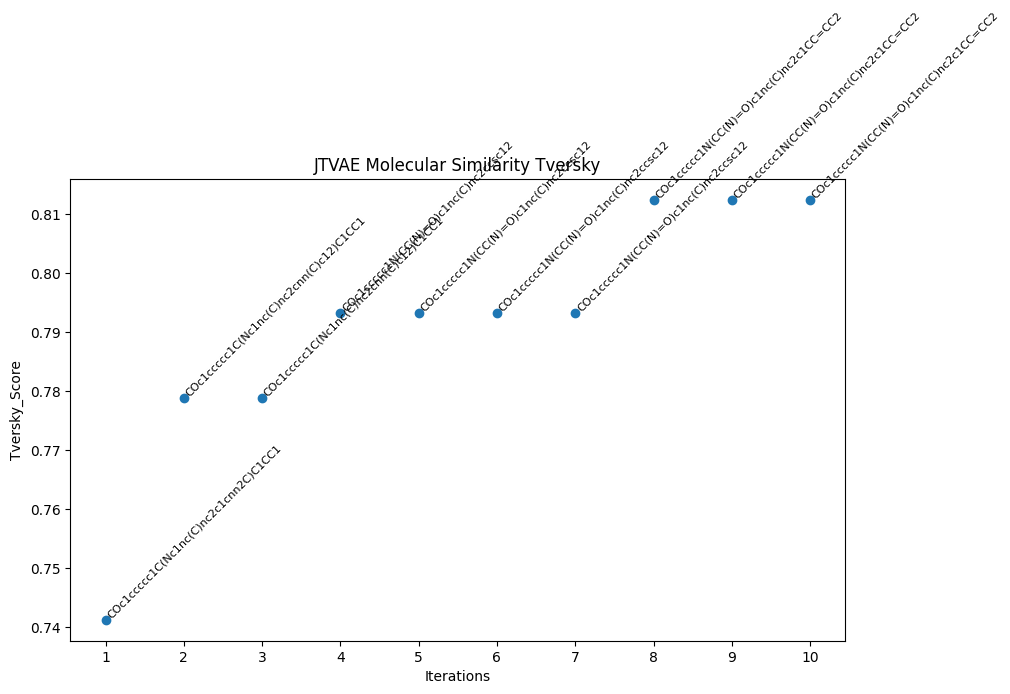

In [39]:
import matplotlib.pyplot as plt

iterations = range(1, len(smiles_list) + 1)

plt.figure(figsize=(10, 6))
plt.scatter(iterations, best_eval)
plt.xticks(iterations, rotation='horizontal')


# Add labels for each dot
for i, (x, y) in enumerate(zip(iterations, best_eval)):
    plt.text(x, y, smiles_list[i], ha='left', va='bottom', rotation=45, fontsize=8)

plt.ylabel('Tversky_Score')
plt.xlabel('Iterations')
plt.title('JTVAE Molecular Similarity Tversky')
plt.show()


In [40]:
import plotly.graph_objects as go

iterations = list(range(1, len(smiles_list) + 1)) # Convert to list for plotly

fig = go.Figure()

fig.add_trace(go.Scatter(x=iterations, y=best_eval,
                         mode='markers',
                         name='Float Values',
                         marker=dict(size=10)))

# Add an annotation for each point
for i in range(len(iterations)):
    fig.add_annotation(x=iterations[i], y=best_eval[i],
                       text=smiles_list[i],
                       showarrow=False,
                       font=dict(size=8),
                       xanchor='left',
                       yanchor='bottom',
                       textangle=-90)  # set textangle to -90 for vertical text

fig.update_layout(title='JTVAE Molecular Similarity Tversky',
                  xaxis=dict(title='Iterations'),
                  yaxis=dict(title='Tversky_Score'),  # Update y-axis title
                  autosize=False,
                  width=1000,
                  height=600)

fig.show()
